In [1]:
# imports of both spynnaker and external device plugin.
import spynnaker.pyNN as Frontend
import spynnaker_external_devices_plugin.pyNN as ExternalDevices

#######################
# import to allow prefix type for the prefix eieio protocol
######################
from spynnaker_external_devices_plugin.pyNN.connections\
    .spynnaker_live_spikes_connection import SpynnakerLiveSpikesConnection

# plotter in python
%matplotlib notebook
import matplotlib.pyplot as plt

import time
import numpy

In [2]:
n_neurons = 3000

run_time = 1000 # timeScaleFactor  = 10

In [3]:
# initial call to set up the front end (pynn requirement)
Frontend.setup(timestep=1.0) #, min_delay=1.0, max_delay=144.0)


cell_params_lif = {'cm': 0.25,
                   'i_offset': 0.0,
                   'tau_m': 20.0,
                   'tau_refrac': 2.0,
                   'tau_syn_E': 5.0,
                   'tau_syn_I': 5.0,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -50.0
                   }


weight_to_spike = 5.0

# create ORDINARY populations
pop_input = Frontend.Population(
    n_neurons/10, Frontend.IF_curr_exp,
    cell_params_lif, label='pop_input')

pop_output = Frontend.Population(
    n_neurons, Frontend.IF_curr_exp,
    cell_params_lif, label='pop_output')

# Create EXTERNAL INJECTION population
spike_injector = Frontend.Population(
    n_neurons, ExternalDevices.SpikeInjector,
    {'port': 12345,
     'database_notify_host':"localhost",
     'database_notify_port_num':12346},
    label='spike_injector')

# port: internal port on SpiNNaker (you just can't use the same value to multiple SpikeInjectors)
#       it's only really usefull if you are NOT using the spynnaker_live_spikes_connection.
# database_notify_host: ip where the spikes are comming from (if using spynnaker_live_spikes_connection)
# database_notify_port_num: port where the spikes are comming from (if using spynnaker_live_spikes_connection)

# Create a connection from the injector into the input population
Frontend.Projection(
    spike_injector, pop_input,
    Frontend.OneToOneConnector(weights=weight_to_spike),target='excitatory')


# Propagates the spikes from pop_input to pop_output
Frontend.Projection(
    pop_input, pop_output,
    Frontend.OneToOneConnector(weights=weight_to_spike))
#     Frontend.AllToAllConnector(weights=weight_to_spike),target='excitatory')


# record spikes so that we can read off valid
# results in a safe way afterwards, and verify the behavior
pop_input.record()
pop_output.record()

# Activate the SENDING of live spikes from the pop_output
ExternalDevices.activate_live_output_for(
    pop_output, 
    database_notify_host="localhost",
    database_notify_port_num=12346)


# Run the simulation on spiNNaker
Frontend.run(run_time)


# Retrieve spikes from the synfire chain population
spikes_input = pop_input.getSpikes()
spikes_output = pop_output.getSpikes()

# Clear data structures on spiNNaker to leave the machine in a clean
# state for future executions
Frontend.end()

Allocating virtual identifiers
|0                           50%                         100%|
Partitioning graph vertices
|0                           50%                         100%|
Partitioning graph edges
|0                           50%                         100%|
Generating partitioner report
|0                           50%                         100%|
Filtering edges
|0                           50%                         100%|
Placing graph vertices
|0                           50%                         100%|
Generating placement report
|0                           50%                         100%|
Generating placement by core report
|0                           50%                         100%|
Generating SDRAM usage report
|0                           50%                         100%|
Routing
|0                           50%                         100%|
Allocating tags
|0                           50%                         100%|
Reporting Tags
|0                   

<IPython.core.display.Javascript object>


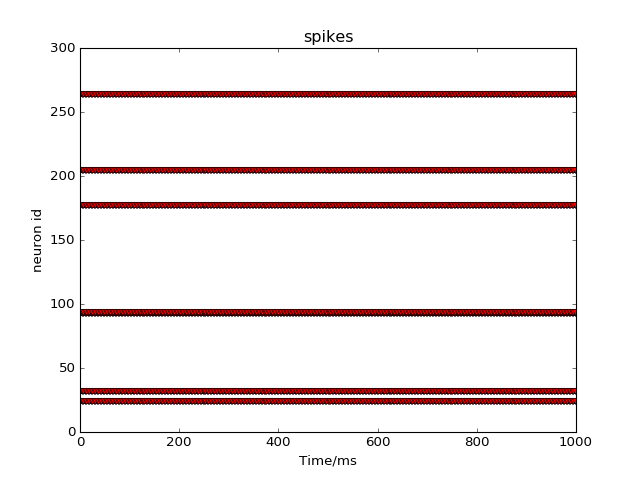

In [4]:

# If there are spikes, plot using matplotlib
if len(spikes_input) != 0 or len(spikes_output) != 0:
    plt.figure()
    if len(spikes_input) != 0:
        plt.plot([i[1] for i in spikes_input],
                   [i[0] for i in spikes_input], "bo", markersize=5, label="input")
    if len(spikes_output) != 0:
        plt.plot([i[1] for i in spikes_output],
                   [i[0] for i in spikes_output], "rv", label="output")
    plt.ylabel('neuron id')
    plt.xlabel('Time/ms')
    plt.title('spikes')
#     plt.xlim(450,650)
    plt.show()
else:
    print "No spikes received"
